In [ ]:
# IMPORTS GENERALES
import os
from pathlib import Path
import io, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from math import sqrt
from google.colab import files

from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score
)







In [ ]:
#CARGA DE ARCHIVOS
uploaded = files.upload()  # seleccioná: base respondieron.xlsx, base norespondieron.xlsx

print("Archivos subidos:", list(uploaded.keys()))
norespondieron = pd.read_excel(list(uploaded.keys())[0])
respondieron = pd.read_excel(list(uploaded.keys())[1])

# Estandarizar nombres de columnas
def clean_cols(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(r'\s+', '_', regex=True)
        .str.replace(r'[^0-9A-Za-z_]+', '', regex=True)
        .str.upper()
    )
    return df

respondieron = clean_cols(respondieron)
norespondieron = clean_cols(norespondieron)

Saving base norespondieron.xlsx to base norespondieron.xlsx
Saving base respondieron.xlsx to base respondieron.xlsx
Archivos subidos: ['base norespondieron.xlsx', 'base respondieron.xlsx']


In [ ]:
print("Base respondieron")
display(respondieron.head())
display(respondieron.columns)

print("")
print("")

print("Base no resopndieron")
display(norespondieron.head())
display(norespondieron.columns)

Base respondieron


,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,P47T,PP04B_COD,PP07A,PP07C,MAS_500,CH03,ANIO,AD_EQUIV_HOGAR3,CBT_AE,INGRESO_NECESARIO,POBRE
0,1,80,4,1,3,3,1,583.0,583,583,,0.0,0.0,S,1,2005,0.74,205.07,151.7518,0
1,1,26,2,4,4,1,0,150.0,450,450,5311,0.0,0.0,S,1,2005,1.78,205.07,365.0246,0
2,2,27,2,4,6,3,4,150.0,450,0,,0.0,0.0,S,2,2005,1.78,205.07,365.0246,0
3,2,-1,5,4,7,4,5,150.0,450,0,,0.0,0.0,S,3,2005,1.78,205.07,365.0246,0
4,2,71,4,1,2,3,1,855.0,855,855,,0.0,0.0,S,1,2005,0.67,205.07,137.3969,0


Index(['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC',
       'IPCF', 'ITF', 'P47T', 'PP04B_COD', 'PP07A', 'PP07C', 'MAS_500', 'CH03',
       'ANIO', 'AD_EQUIV_HOGAR3', 'CBT_AE', 'INGRESO_NECESARIO', 'POBRE'],
      dtype='object')



Base no resopndieron


,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,P47T,PP04B_COD,PP07A,PP07C,MAS_500,CH03,ANIO
0,2,39,3,2,5,2,0,0,0,0.0,,0.0,0.0,S,1,2005
1,1,16,5,2,3,3,3,0,0,0.0,,0.0,0.0,S,3,2005
2,2,14,5,2,3,3,3,0,0,0.0,,0.0,0.0,S,3,2005
3,2,8,5,2,1,4,3,0,0,0.0,,0.0,0.0,S,3,2005
4,1,62,1,1,3,3,7,0,0,0.0,,0.0,0.0,S,1,2005


Index(['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC',
       'IPCF', 'ITF', 'P47T', 'PP04B_COD', 'PP07A', 'PP07C', 'MAS_500', 'CH03',
       'ANIO'],
      dtype='object')

In [ ]:
drop_vars = ['IPCF', 'ITF', 'P47T',
    'AD_EQUIV_HOGAR3', 'CBT_AE', 'INGRESO_NECESARIO',
    'POBRE','ANIO']

# Construir matriz X y vector y
X = respondieron.drop(columns=drop_vars, errors='ignore').copy()
y = respondieron['POBRE'].astype(int)

# Agregar columna de unos (intercepto)
X['INTERCEPTO'] = 1

# DIVISIÓN TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=444, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# TABLA DE DIFERENCIAS DE MEDIAS ENTRE TRAIN Y TEST
# Seleccionamos solo columnas numéricas
num_cols = X_train.select_dtypes(include=[np.number]).columns

mean_train = X_train[num_cols].mean()
mean_test = X_test[num_cols].mean()
diff = mean_train - mean_test

# t de Student entre grupos
tstats, pvals = stats.ttest_ind(
    X_train[num_cols], X_test[num_cols], nan_policy='omit', equal_var=False
)

tabla_diff = pd.DataFrame({
    'MEDIA_TRAIN': mean_train,
    'MEDIA_TEST': mean_test,
    'DIFERENCIA': diff,
    'T_STAT': tstats,
    'P_VALOR': pvals
}).round(3)

# Ordenar por magnitud de la diferencia
tabla_diff = tabla_diff.reindex(
    tabla_diff['DIFERENCIA'].abs().sort_values(ascending=False).index
)

print("        --- TABLA DE DIFERENCIAS DE MEDIAS ENTRE TRAIN Y TEST ---")
display(tabla_diff)

# COMENTARIO
sig_dif = (tabla_diff['P_VALOR'] < 0.05).sum()
total_vars = len(tabla_diff)
print(f"\n De {total_vars} variables numéricas, {sig_dif} presentan diferencias significativas (p<0.05).")

Train: (9576, 13), Test: (4104, 13)
        --- TABLA DE DIFERENCIAS DE MEDIAS ENTRE TRAIN Y TEST ---


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:627: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds), n_out)


,MEDIA_TRAIN,MEDIA_TEST,DIFERENCIA,T_STAT,P_VALOR
CH06,34.779,35.079,-0.299,-0.706,0.480
NIVEL_ED,3.557,3.597,-0.040,-1.127,0.260
PP07A,1.704,1.739,-0.036,-0.692,0.489
CH03,2.422,2.395,0.026,0.932,0.351
CH07,3.479,3.464,0.015,0.506,0.613
CH04,1.526,1.522,0.004,0.392,0.695
PP07C,0.815,0.819,-0.004,-0.124,0.901
CH08,2.347,2.350,-0.003,-0.103,0.918
CAT_INAC,1.710,1.709,0.001,0.028,0.978
ESTADO,2.234,2.234,-0.000,-0.019,0.985



 De 11 variables numéricas, 0 presentan diferencias significativas (p<0.05).


In [ ]:
# Separar respondieron dataframe por año
respondieron_2005 = respondieron[respondieron['ANIO'] == 2005].copy()
respondieron_2025 = respondieron[respondieron['ANIO'] == 2025].copy()

# Separar norespondieron dataframe por año
norespondieron_2005 = norespondieron[norespondieron['ANIO'] == 2005].copy()
norespondieron_2025 = norespondieron[norespondieron['ANIO'] == 2025].copy()


print("Shape of respondieron_2005:", respondieron_2005.shape)
print("Shape of respondieron_2025:", respondieron_2025.shape)
print("Shape of norespondieron_2005:", norespondieron_2005.shape)
print("Shape of norespondieron_2025:", norespondieron_2025.shape)

Shape of respondieron_2005: (9371, 20)
Shape of respondieron_2025: (4309, 20)
Shape of norespondieron_2005: (113, 16)
Shape of norespondieron_2025: (2872, 16)


# TP 4


In [ ]:
# Construir X_2025 y y_2025

# Variables que NO entran como predictoras (mismas que definiste arriba)
drop_vars = ['IPCF', 'ITF', 'P47T',
             'AD_EQUIV_HOGAR3', 'CBT_AE', 'INGRESO_NECESARIO',
             'POBRE', 'ANIO']

# Definir y (variable objetivo)
y_2025 = respondieron_2025['POBRE'].astype(int).copy()

# Definir X eliminando drop_vars
X_2025 = respondieron_2025.drop(columns=drop_vars, errors='ignore').copy()


print("Shape de X_2025:", X_2025.shape)
print("Shape de y_2025:", y_2025.shape)

print("\nColumnas de X_2025:")
print(list(X_2025.columns))


Shape de X_2025: (4309, 12)
Shape de y_2025: (4309,)

Columnas de X_2025:
['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'PP04B_COD', 'PP07A', 'PP07C', 'MAS_500', 'CH03']


In [ ]:
X_train_2025, X_test_2025, y_train_2025, y_test_2025 = train_test_split(
    X_2025,
    y_2025,
    test_size=0.30,
    random_state=444,
    stratify=y_2025
)

print("X_train_2025:", X_train_2025.shape)
print("X_test_2025:", X_test_2025.shape)
print("y_train_2025:", y_train_2025.shape)
print("y_test_2025:", y_test_2025.shape)

X_train_2025: (3016, 12)
X_test_2025: (1293, 12)
y_train_2025: (3016,)
y_test_2025: (1293,)


In [ ]:
# Identificar columnas numéricas y categóricas EN DATOS CRUDOS
X_train_reg = X_train_2025.copy()

# --- EXCLUIR PP04B PARA REGULARIZACIÓN ---
cols_excluir = ['PP04B_COD']   # dejar fuera PP04B para que no explote en dummies
X_train_reg = X_train_reg.drop(columns=cols_excluir, errors='ignore')
X_test_reg  = X_test_2025.drop(columns=cols_excluir, errors='ignore')

# Detectar tipos de columnas
numerical_cols = X_train_reg.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train_reg.select_dtypes(include='object').columns.tolist()

print("Columnas numéricas (reg):", numerical_cols)
print("Columnas categóricas (reg):", categorical_cols)

# ------------------------------
# PREPROCESADOR SIN PP04B
# ------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),
    ]
)
print("Columnas numéricas:", numerical_cols)
print("Columnas categóricas:", categorical_cols)



Columnas numéricas (reg): ['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'PP07A', 'PP07C', 'CH03']
Columnas categóricas (reg): ['MAS_500']
Columnas numéricas: ['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'PP07A', 'PP07C', 'CH03']
Columnas categóricas: ['MAS_500']


# **EJERCICIO 1**

In [ ]:
# 1. Preprocesador (NO se toca data afuera)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

# 2. Grilla de lambdas
n_values = np.arange(-5, 6)          # [-5, -4, ..., 4, 5]
lambdas = 10.0 ** n_values           # λ = 10^n
Cs = 1.0 / lambdas                   # C = 1/λ

# 3. Listas donde guardamos coeficientes
temp_lasso_coefs = []
temp_ridge_coefs = []

# 4. Loop para cada valor de C
for C_val in Cs:

    # --- LASSO (L1) ---
    pipe_l1 = Pipeline([
        ('pre', preprocessor),
        ('clf', LogisticRegression(
            penalty='l1',
            solver='saga',
            C=C_val,
            max_iter=5000
        ))
    ])
    pipe_l1.fit(X_train_2025, y_train_2025)
    coef_l1_vals = pipe_l1['clf'].coef_.flatten()
    temp_lasso_coefs.append(coef_l1_vals)

    # --- RIDGE (L2) ---
    pipe_l2 = Pipeline([
        ('pre', preprocessor),
        ('clf', LogisticRegression(
            penalty='l2',
            solver='lbfgs',
            C=C_val,
            max_iter=5000
        ))
    ])
    pipe_l2.fit(X_train_2025, y_train_2025)
    coef_l2_vals = pipe_l2['clf'].coef_.flatten()
    temp_ridge_coefs.append(coef_l2_vals)

# 5. Obtener nombres de variables DESPUÉS de ajustar un pipeline
fitted_pre = pipe_l1.named_steps['pre']   # el último pipe_l1 tiene el preprocesador ajustado

feature_names = (
    list(numerical_cols) +
    list(
        fitted_pre.named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_cols)
    )
)

# 6. Convertir listas a DataFrames (filas = variables, columnas = lambdas)
coef_l1 = pd.DataFrame(
    np.array(temp_lasso_coefs).T,
    index=feature_names,
    columns=lambdas
)
coef_l2 = pd.DataFrame(
    np.array(temp_ridge_coefs).T,
    index=feature_names,
    columns=lambdas
)

print("Listo. Coeficientes calculados para LASSO y RIDGE sin leakage.")
print("Dimensión LASSO (variables x lambdas):", coef_l1.shape)
print("Dimensión RIDGE (variables x lambdas):", coef_l2.shape)

Listo. Coeficientes calculados para LASSO y RIDGE sin leakage.
Dimensión LASSO (variables x lambdas): (11, 11)
Dimensión RIDGE (variables x lambdas): (11, 11)


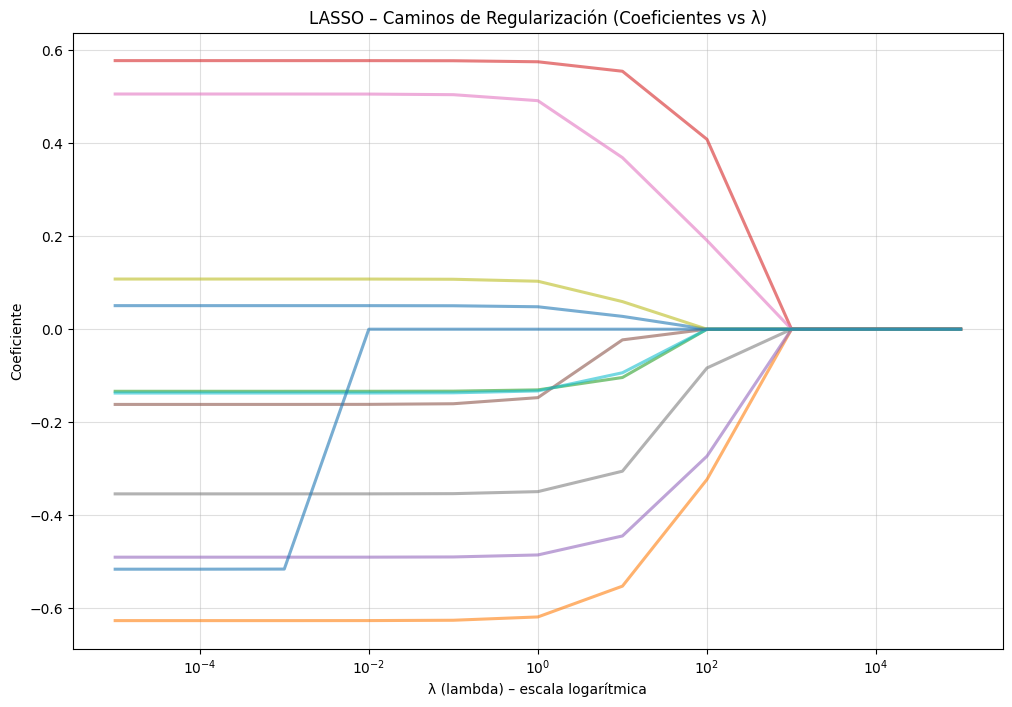

In [ ]:
# GRÁFICO: Caminos de regularización LASSO
# ============================================

plt.figure(figsize=(12, 8))

# coef_l1 tiene dimensiones (variables x lambdas)
# Hacemos el plot de cada fila = cada variable

for i in range(coef_l1.shape[0]):
    plt.plot(
        lambdas,
        coef_l1.iloc[i, :],
        linewidth=2.2,       # líneas gruesas
        alpha=0.6            # leve transparencia para no saturar
    )

plt.xscale("log")
plt.xlabel("λ (lambda) – escala logarítmica")
plt.ylabel("Coeficiente")
plt.title("LASSO – Caminos de Regularización (Coeficientes vs λ)")
plt.grid(True, alpha=0.4)

plt.show()

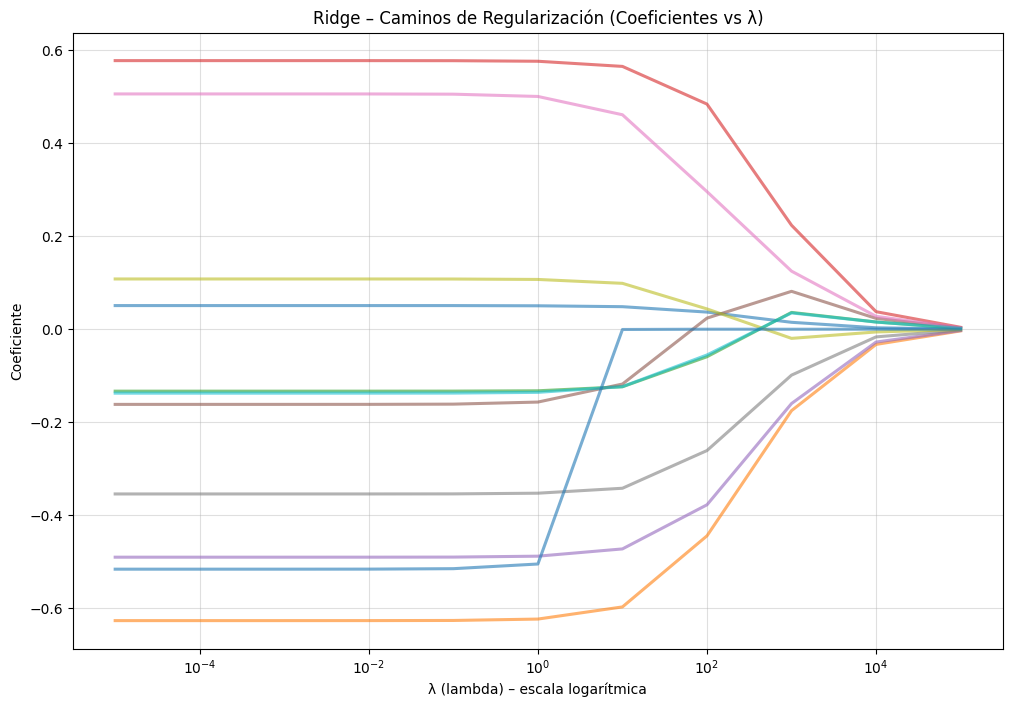

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(coef_l2.shape[0]):
    plt.plot(
        lambdas,
        coef_l2.iloc[i, :],
        linewidth=2.2,
        alpha=0.6
    )

plt.xscale("log")
plt.xlabel("λ (lambda) – escala logarítmica")
plt.ylabel("Coeficiente")
plt.title("Ridge – Caminos de Regularización (Coeficientes vs λ)")
plt.grid(True, alpha=0.4)
plt.show()

# **EJERCICIO 2**


--- Entrenando modelo LogisticRegressionCV con LASSO (L1) ---
Entrenamiento LASSO completado.

--- Entrenando modelo LogisticRegressionCV con RIDGE (L2) ---
Entrenamiento Ridge completado.

C óptimo para LASSO: 10.000000  (λ óptimo ≈ 1.00e-01)
C óptimo para RIDGE: 100000.000000  (λ óptimo ≈ 1.00e-05)


/tmp/ipython-input-2890857498.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(
/tmp/ipython-input-2890857498.py:95: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


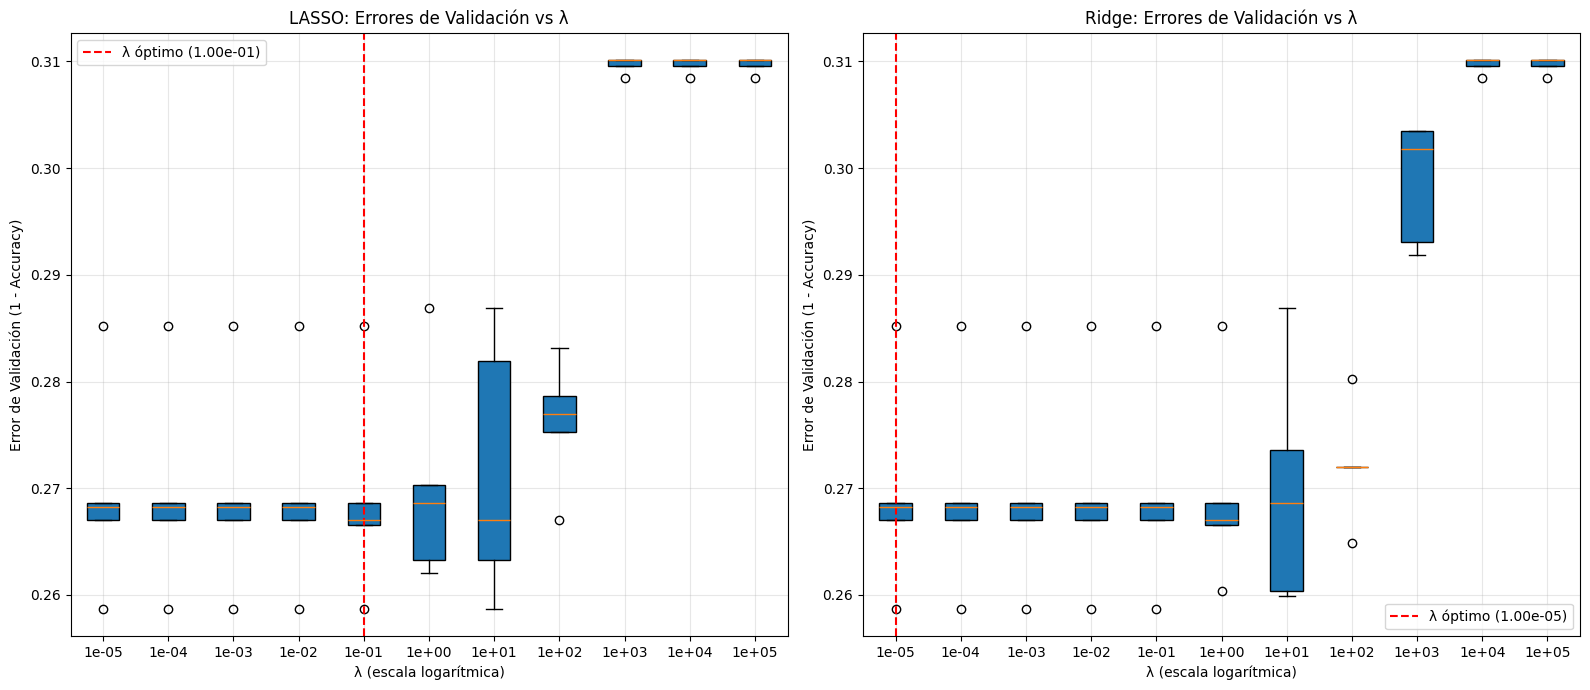

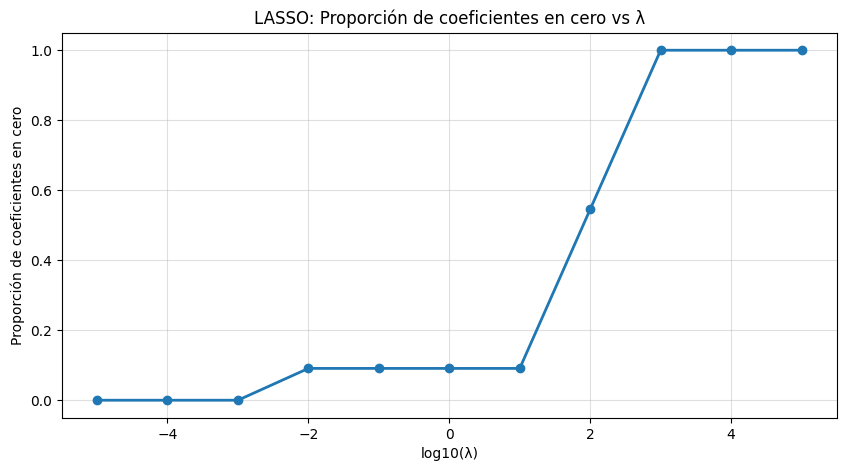

In [ ]:
## EJERCICIO 2 – Selección de λ óptimo (LASSO y RIDGE)
# ============================================

from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline

# 1) Armamos pipelines con el mismo preprocesador del Ejercicio 1

pipe_l1_cv = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegressionCV(
        penalty='l1',
        solver='saga',
        Cs=Cs,                # misma grilla de C = 1 / lambdas
        cv=5,
        scoring='accuracy',
        max_iter=5000,
        n_jobs=-1,
        refit=True
    ))
])

pipe_l2_cv = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegressionCV(
        penalty='l2',
        solver='lbfgs',
        Cs=Cs,
        cv=5,
        scoring='accuracy',
        max_iter=5000,
        n_jobs=-1,
        refit=True
    ))
])

print("\n--- Entrenando modelo LogisticRegressionCV con LASSO (L1) ---")
pipe_l1_cv.fit(X_train_2025, y_train_2025)
print("Entrenamiento LASSO completado.")

print("\n--- Entrenando modelo LogisticRegressionCV con RIDGE (L2) ---")
pipe_l2_cv.fit(X_train_2025, y_train_2025)
print("Entrenamiento Ridge completado.")

# 2) Extraemos los objetos clf (paso de la regresión logística)

clf_l1 = pipe_l1_cv.named_steps['clf']
clf_l2 = pipe_l2_cv.named_steps['clf']

# 3) C óptimo y λ óptimo (λ = 1 / C)

l1_opt_C = clf_l1.C_[0]
l2_opt_C = clf_l2.C_[0]

l1_opt_lambda = 1.0 / l1_opt_C
l2_opt_lambda = 1.0 / l2_opt_C

print(f"\nC óptimo para LASSO: {l1_opt_C:.6f}  (λ óptimo ≈ {l1_opt_lambda:.2e})")
print(f"C óptimo para RIDGE: {l2_opt_C:.6f}  (λ óptimo ≈ {l2_opt_lambda:.2e})")

# 4) Errores de validación (1 - accuracy) para cada λ

# la llave de scores_ es la clase (0 o 1); tomo la primera
key_l1 = list(clf_l1.scores_.keys())[0]
key_l2 = list(clf_l2.scores_.keys())[0]

l1_errors = 1 - clf_l1.scores_[key_l1]   # shape: (n_obs_cv, n_lambdas)
l2_errors = 1 - clf_l2.scores_[key_l2]

# Posición del C óptimo dentro del vector Cs (para dibujar la línea roja)
idx_l1 = list(Cs).index(l1_opt_C)
idx_l2 = list(Cs).index(l2_opt_C)

lambda_labels = [f"{lam:.0e}" for lam in lambdas]   # etiquetas tipo 1e-5, 1e-4, ...

plt.figure(figsize=(16, 7))

# ----- Boxplot LASSO -----
plt.subplot(1, 2, 1)
plt.boxplot(
    [l1_errors[:, j] for j in range(len(Cs))],
    labels=lambda_labels,
    patch_artist=True
)
plt.axvline(idx_l1 + 1, color='red', linestyle='--',
            label=f"λ óptimo ({l1_opt_lambda:.2e})")
plt.xlabel("λ (escala logarítmica)")
plt.ylabel("Error de Validación (1 - Accuracy)")
plt.title("LASSO: Errores de Validación vs λ")
plt.grid(alpha=0.3)
plt.legend()

# ----- Boxplot RIDGE -----
plt.subplot(1, 2, 2)
plt.boxplot(
    [l2_errors[:, j] for j in range(len(Cs))],
    labels=lambda_labels,
    patch_artist=True
)
plt.axvline(idx_l2 + 1, color='red', linestyle='--',
            label=f"λ óptimo ({l2_opt_lambda:.2e})")
plt.xlabel("λ (escala logarítmica)")
plt.ylabel("Error de Validación (1 - Accuracy)")
plt.title("Ridge: Errores de Validación vs λ")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# 5) Proporción de coeficientes en cero para cada λ (usando coef_l1 del Ejercicio 1)

# coef_l1 tiene dimensión: variables x lambdas
zero_prop = (coef_l1 == 0).sum(axis=0) / coef_l1.shape[0]

plt.figure(figsize=(10, 5))
plt.plot(
    np.log10(lambdas),
    zero_prop,
    marker='o',
    linewidth=2
)
plt.xlabel("log10(λ)")
plt.ylabel("Proporción de coeficientes en cero")
plt.title("LASSO: Proporción de coeficientes en cero vs λ")
plt.grid(alpha=0.4)
plt.show()



# **EJERCICIO 3**

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),                #El preprocessor del Ejercicio 3 tiene que ser EXACTAMENTE el mismo que definiste en el Ejercicio 2.
            ('scaler', StandardScaler())
        ]), numerical_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),
    ]
)

In [ ]:
l1_opt_C = 1.0 / l1_opt_lambda
l2_opt_C = 1.0 / l2_opt_lambda


In [ ]:

# 1. Definir los tres modelos logit dentro de pipelines con el MISMO preprocesador
pipe_none = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(
        penalty=None,
        solver='lbfgs',
        max_iter=3000
    ))
])

pipe_l1 = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(
        penalty='l1',
        C=l1_opt_C,          # C óptimo del Ejercicio 2 (LASSO)
        solver='liblinear',
        max_iter=3000
    ))
])

pipe_l2 = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(
        penalty='l2',
        C=l2_opt_C,          # C óptimo del Ejercicio 2 (Ridge)
        solver='lbfgs',
        max_iter=3000
    ))
])

# 2. Ajustar los tres modelos sobre X_train_2025, y_train_2025
pipe_none.fit(X_train_2025, y_train_2025)
pipe_l1.fit(X_train_2025, y_train_2025)
pipe_l2.fit(X_train_2025, y_train_2025)

print("Modelos logit del Ejercicio 3 entrenados correctamente.\n")

# 3. Obtener nombres de variables DESPUÉS del OneHot, coherentes con Ej 1–2
pre_fitted = pipe_none.named_steps['pre']

feature_names = (
    list(numerical_cols) +
    list(
        pre_fitted.named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_cols)
    )
)

# 4. Extraer coeficientes de cada modelo
coef_none = pipe_none.named_steps['clf'].coef_[0]
coef_l1   = pipe_l1.named_steps['clf'].coef_[0]
coef_l2   = pipe_l2.named_steps['clf'].coef_[0]

# 5. Construir tabla comparativa
coef_df = pd.DataFrame(
    {
        'coef_sin_penalidad': coef_none,
        'coef_L1': coef_l1,
        'coef_L2': coef_l2
    },
    index=feature_names
)

print("Tabla de coeficientes (sin redondear):\n")
print(coef_df)

# 6. (Opcional pero útil) guardar estos objetos para usar luego en Ej 5 y 6
model_none = pipe_none
model_l1   = pipe_l1
model_l2   = pipe_l2
coef_l1_ej3 = coef_l1
coef_df.round(4)

Modelos logit del Ejercicio 3 entrenados correctamente.

Tabla de coeficientes (sin redondear):

           coef_sin_penalidad   coef_L1   coef_L2
CH04                 0.050744  0.050402  0.050744
CH06                -0.626343 -0.625427 -0.626343
CH07                -0.133167 -0.133170 -0.133167
CH08                 0.577198  0.576972  0.577198
NIVEL_ED            -0.489998 -0.489393 -0.489998
ESTADO              -0.161606 -0.159833 -0.161606
CAT_INAC             0.505621  0.503684  0.505621
PP07A               -0.354103 -0.353405 -0.354103
PP07C                0.107928  0.107362  0.107928
CH03                -0.137475 -0.136662 -0.137475
MAS_500_S           -0.515759 -0.179472 -0.515759


,coef_sin_penalidad,coef_L1,coef_L2
CH04,0.0507,0.0504,0.0507
CH06,-0.6263,-0.6254,-0.6263
CH07,-0.1332,-0.1332,-0.1332
CH08,0.5772,0.5770,0.5772
NIVEL_ED,-0.4900,-0.4894,-0.4900
ESTADO,-0.1616,-0.1598,-0.1616
CAT_INAC,0.5056,0.5037,0.5056
PP07A,-0.3541,-0.3534,-0.3541
PP07C,0.1079,0.1074,0.1079
CH03,-0.1375,-0.1367,-0.1375


# **EJERCICIO 4**

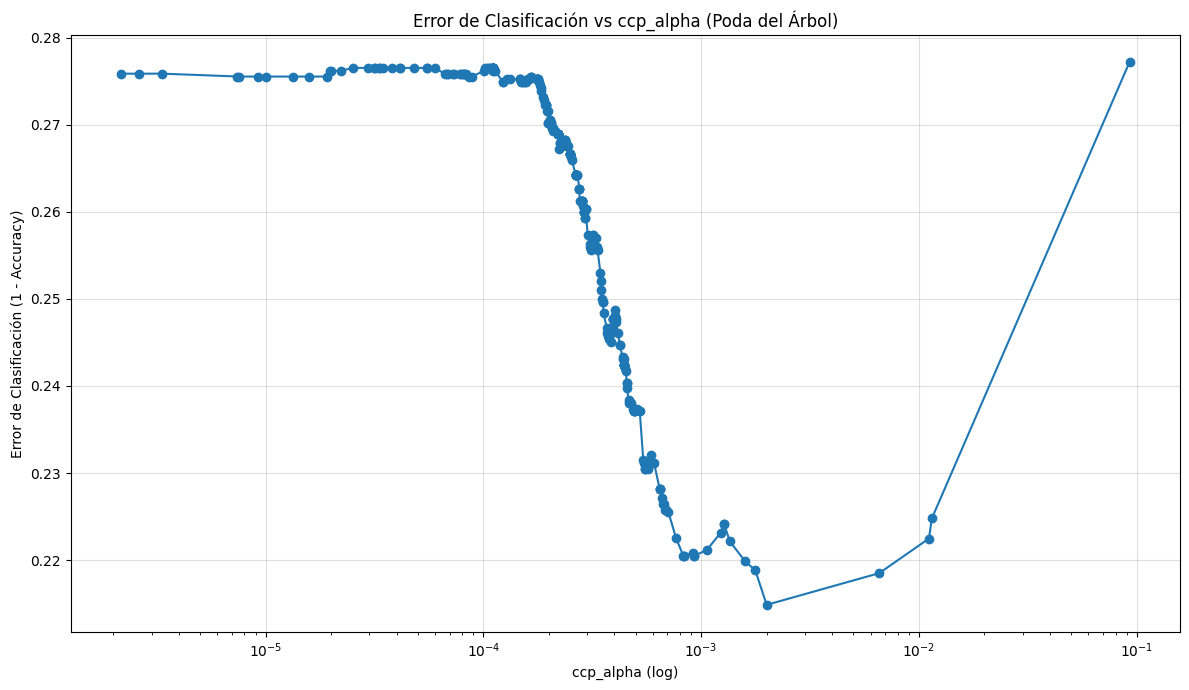

In [ ]:


# --- Usar datos crudos originales ---
X_tree = X_train_2025.copy()
y_tree = y_train_2025.copy()

# --- (Opcional) quitar PP04B_COD si lo estabas quitando ---
if 'PP04B_COD' in X_tree.columns:
    X_tree = X_tree.drop(columns=['PP04B_COD'])

# --- Aplicar el preprocessor SOLO para convertir strings a números ---

preprocessor.fit(X_tree)
X_tree_enc = preprocessor.transform(X_tree)

# --- Árbol base sin poda para obtener ruta de CC alphas ---
base_tree = DecisionTreeClassifier(random_state=444)
path = base_tree.cost_complexity_pruning_path(X_tree_enc, y_tree)

ccp_alphas = path.ccp_alphas
ccp_alphas_to_test = ccp_alphas[ccp_alphas > 1e-8]

# --- CV estratificada ---
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=444)

accuracy_scores_per_alpha = []

for ccp_alpha in ccp_alphas_to_test:
    tree = DecisionTreeClassifier(random_state=444, ccp_alpha=ccp_alpha)
    scores = cross_val_score(tree, X_tree_enc, y_tree, cv=cv, scoring='accuracy')
    accuracy_scores_per_alpha.append(scores)

accuracy_scores_per_alpha = np.array(accuracy_scores_per_alpha)
mean_acc = accuracy_scores_per_alpha.mean(axis=1)
classification_errors = 1 - mean_acc

# --- Gráfico final (nada repetido, solo lo necesario) ---
plt.figure(figsize=(12,7))
plt.plot(ccp_alphas_to_test, classification_errors, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel("ccp_alpha (log)")
plt.ylabel("Error de Clasificación (1 - Accuracy)")
plt.title("Error de Clasificación vs ccp_alpha (Poda del Árbol)")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# **EJERCICIO 5**

Valor óptimo de ccp_alpha (best_alpha): 0.002000


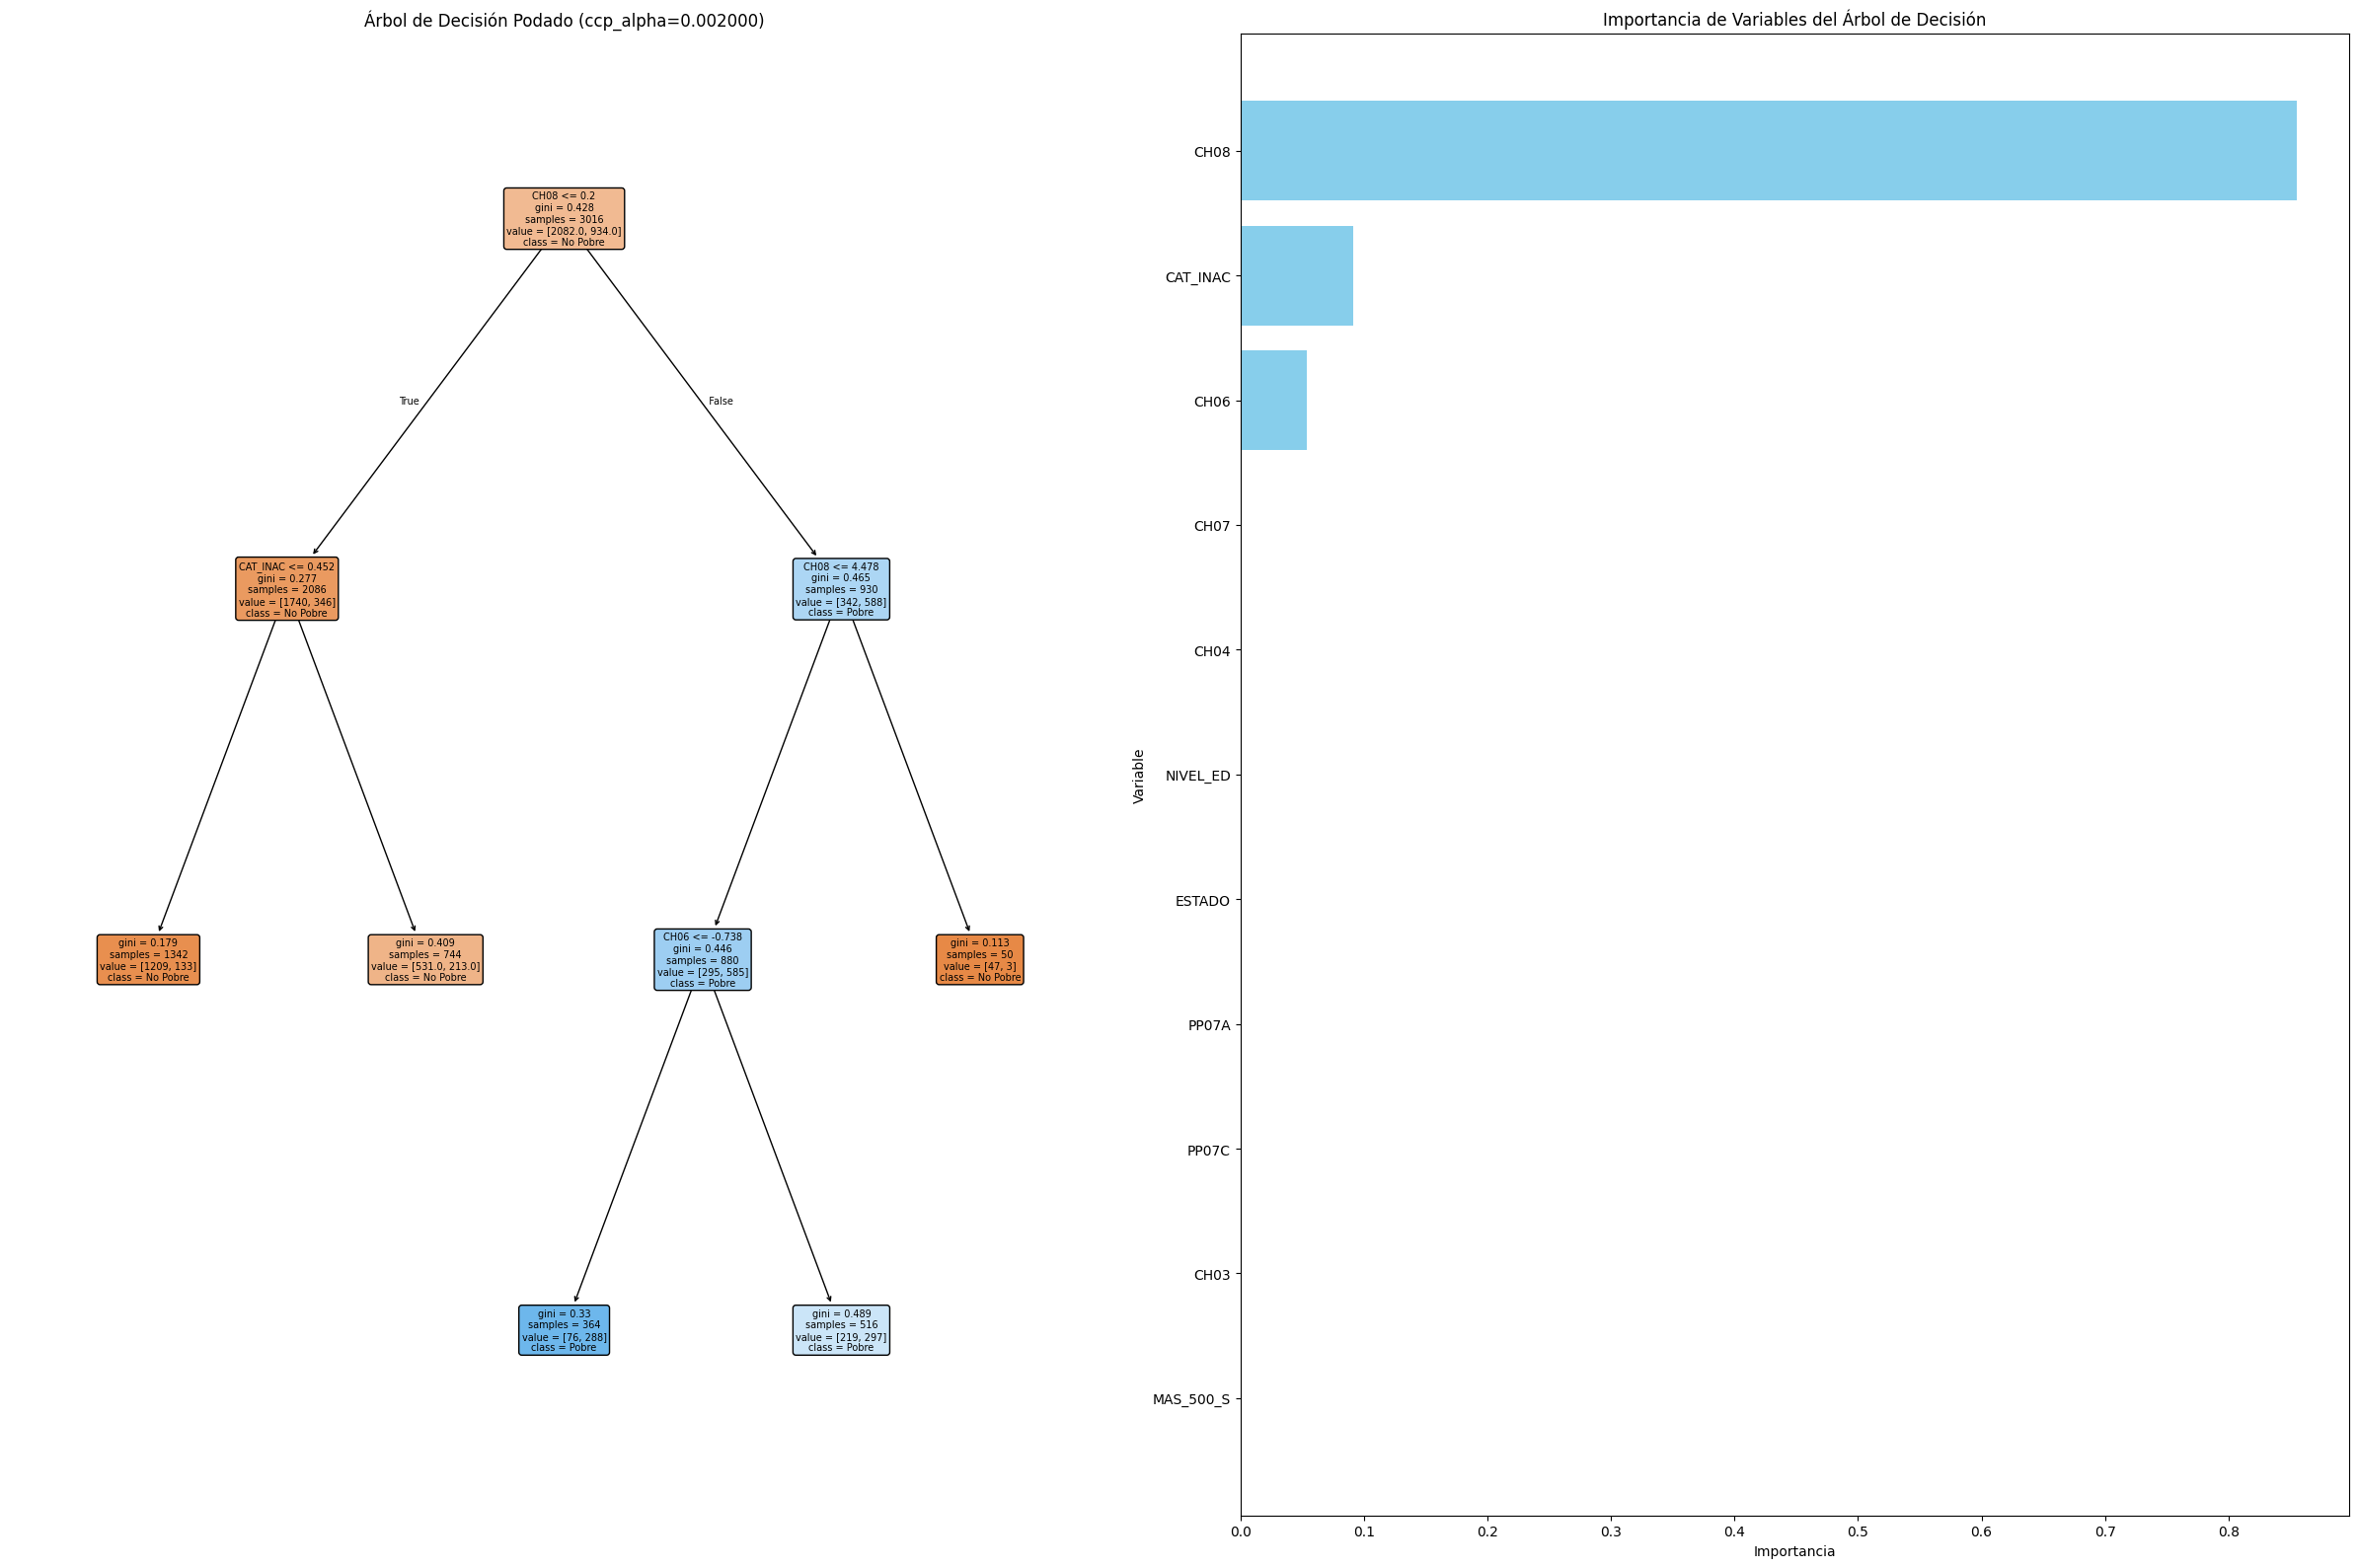

Gráficos generados correctamente.

=== Comparación LASSO vs Árbol (variables irrelevantes) ===
     Variable  Coef_LASSO  Imp_Árbol  LASSO_casi_cero  Árbol_casi_cero
0        CH04    0.050402   0.000000            False             True
2        CH07   -0.133170   0.000000            False             True
5      ESTADO   -0.159833   0.000000            False             True
4    NIVEL_ED   -0.489393   0.000000            False             True
7       PP07A   -0.353405   0.000000            False             True
10  MAS_500_S   -0.179472   0.000000            False             True
9        CH03   -0.136662   0.000000            False             True
8       PP07C    0.107362   0.000000            False             True
1        CH06   -0.625427   0.053959            False            False
6    CAT_INAC    0.503684   0.091188            False            False
3        CH08    0.576972   0.854854            False            False


In [ ]:

# EJERCICIO 5 – Árbol final + Importancia + Comparación con LASSO
# ============================

# 1. Determinar el best_alpha del ejercicio 4
min_error_idx = np.argmin(classification_errors)
best_alpha = ccp_alphas_to_test[min_error_idx]
print(f"Valor óptimo de ccp_alpha (best_alpha): {best_alpha:.6f}")

# 2. Ajustar el árbol definitivo sobre X_tree_enc (datos ya preprocesados SIN PP04B)
final_tree_model = DecisionTreeClassifier(
    ccp_alpha=best_alpha,
    random_state=444
)
final_tree_model.fit(X_tree_enc, y_tree)

# 3. Obtener nombres reales de variables LUEGO del preprocessor
#    (esto ya lo tenías creado arriba)
feature_names_tree = feature_names  # coherente con tu notebook

# 4. Gráfico del árbol podado + Importancia de variables
plt.figure(figsize=(24, 16))

# ---- Panel A: Árbol ----
plt.subplot(1, 2, 1)
plot_tree(
    final_tree_model,
    feature_names=feature_names_tree,
    class_names=['No Pobre', 'Pobre'],
    filled=True,
    rounded=True,
    fontsize=7
)
plt.title(f"Árbol de Decisión Podado (ccp_alpha={best_alpha:.6f})")

# ---- Panel B: Importancia de variables ----
plt.subplot(1, 2, 2)

importance_df = pd.DataFrame({
    'Feature': feature_names_tree,
    'Importance': final_tree_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.title("Importancia de Variables del Árbol de Decisión")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Gráficos generados correctamente.")


# ======================================================
# 5. Comparación formal: Árbol vs LASSO

# ======================================================

# FIX: Use the 'coef_l1' calculated in Ejercicio 3, which has the correct dimensions.
# 'model_l1' in the kernel state was an incorrect reference, likely from a previous run.
lasso_coef_ej3 = coef_l1   # from cell zvJ5A0geHehJ (Ejercicio 3)

compare_df = pd.DataFrame({
    'Variable': feature_names_tree,
    'Coef_LASSO': lasso_coef_ej3,
    'Imp_Árbol': final_tree_model.feature_importances_
})

# Agregar columnas binarias “casi cero”
compare_df['LASSO_casi_cero'] = (compare_df['Coef_LASSO'].abs() < 1e-4)
compare_df['Árbol_casi_cero'] = (compare_df['Imp_Árbol'] < 1e-4)

# Ordenar por baja importancia primero (útil para comparar)
compare_df = compare_df.sort_values(by='Imp_Árbol')

print("\n=== Comparación LASSO vs Árbol (variables irrelevantes) ===")
print(compare_df)


# **EJERCICIO 6**

In [ ]:
# === KNN del TP3 (mismas variables CH06 + IPCF_log y mismo K óptimo) ===


# Armamos las columnas que usaba el TP3
df_knn = respondieron_2025[['CH06', 'IPCF', 'POBRE']].copy()
df_knn['IPCF_log'] = np.log(df_knn['IPCF'])

X_knn_total = df_knn[['CH06', 'IPCF_log']]
y_knn_total = df_knn['POBRE'].astype(int)

# Usamos los mismos índices del split 2025 para que todos los modelos comparen en el MISMO test
X_train_knn = X_knn_total.loc[X_train_2025.index]
X_test_knn  = X_knn_total.loc[X_test_2025.index]
y_train_knn = y_train_2025
y_test_knn  = y_test_2025   # mismo y_test para todos

# K óptimo que te dio en el TP3 (cambialo si te había dado otro)
K_OPT_TP3 = 15

knn_tp3 = Pipeline([
    ('imp',  SimpleImputer(strategy='median')),
    ('scal', StandardScaler()),
    ('knn',  KNeighborsClassifier(n_neighbors=K_OPT_TP3))
])

knn_tp3.fit(X_train_knn, y_train_knn)
print("KNN del TP3 reentrenado con K =", K_OPT_TP3)

KNN del TP3 reentrenado con K = 15


In [ ]:
# === Diccionario de modelos para el Ej 6 ===
models = {
    "Logit (TP3)": pipe_none,
    "KNN (TP3)": knn_tp3,
    "Logit-LASSO (TP4)": pipe_l1,
    "Logit-Ridge (TP4)": pipe_l2,
    "CART (TP4)": final_tree_model
}

In [ ]:
resultados = {}
roc_curves = {}

for nombre, modelo in models.items():
    # Elegir qué X usar según el modelo
    if nombre == "KNN (TP3)":
        X_test_input = X_test_knn
    elif "CART" in nombre:
        # Árbol: si lo entrenaste con X ya transformado, usá el mismo encodificado
        X_test_tree = X_test_2025.copy()
        if 'PP04B_COD' in X_test_tree.columns:
            X_test_tree = X_test_tree.drop(columns=['PP04B_COD'])
        X_test_input = preprocessor.transform(X_test_tree)
    else:
        # Logits: reciben X crudo porque el preprocesador está dentro del pipeline
        X_test_input = X_test_2025

    # Predicción de clase
    y_pred = modelo.predict(X_test_input)

    # Probabilidades para ROC (clase 1 = pobre)
    if hasattr(modelo, "predict_proba"):
        y_prob = modelo.predict_proba(X_test_input)[:, 1]
    else:
        # por si algún modelo no tuviera predict_proba
        y_prob = None

    acc  = accuracy_score(y_test_2025, y_pred)
    err  = 1 - acc
    rec  = recall_score(y_test_2025, y_pred)
    prec = precision_score(y_test_2025, y_pred)
    f1   = f1_score(y_test_2025, y_pred)

    if y_prob is not None:
        auc = roc_auc_score(y_test_2025, y_prob)
        fpr, tpr, _ = roc_curve(y_test_2025, y_prob)
        roc_curves[nombre] = (fpr, tpr, auc)
    else:
        auc = None

    resultados[nombre] = {
        "Accuracy": acc,
        "Error (1-Acc)": err,
        "Recall (Pobre)": rec,
        "Precision (Pobre)": prec,
        "F1 (Pobre)": f1,
        "AUC": auc,
        "Matriz_confusion": confusion_matrix(y_test_2025, y_pred)
    }

# Tabla resumen (sin la matriz)
tabla_res = pd.DataFrame({
    nombre: {k: v for k, v in met.items() if k != "Matriz_confusion"}
    for nombre, met in resultados.items()
}).T.round(4)

display(tabla_res)

,Accuracy,Error (1-Acc),Recall (Pobre),Precision (Pobre),F1 (Pobre),AUC
Logit (TP3),0.7061,0.2939,0.4250,0.5312,0.4722,0.7476
KNN (TP3),0.9729,0.0271,0.9475,0.9644,0.9559,0.9970
Logit-LASSO (TP4),0.7061,0.2939,0.4250,0.5312,0.4722,0.7476
Logit-Ridge (TP4),0.7061,0.2939,0.4250,0.5312,0.4722,0.7476
CART (TP4),0.7680,0.2320,0.5850,0.6359,0.6094,0.7647


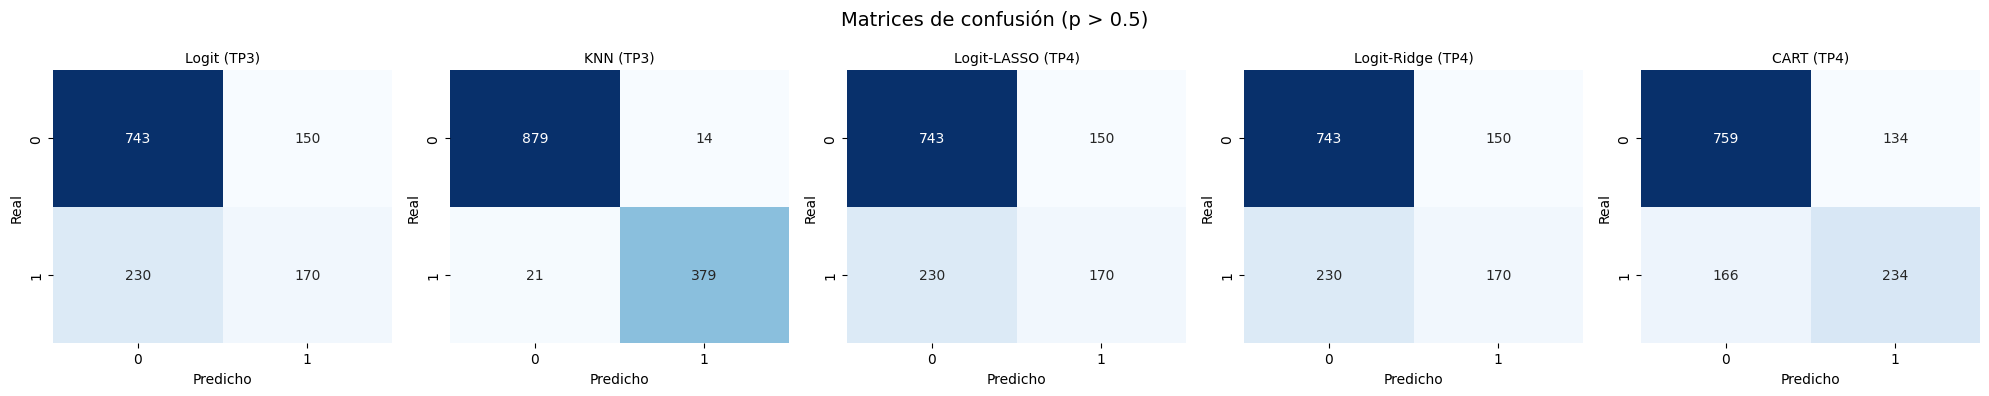

In [ ]:
fig, axes = plt.subplots(1, len(models), figsize=(4*len(models), 4))

for ax, (nombre, met) in zip(axes, resultados.items()):
    cm = met["Matriz_confusion"]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(nombre, fontsize=10)
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")

plt.suptitle("Matrices de confusión (p > 0.5)", fontsize=14)
plt.tight_layout()
plt.show()

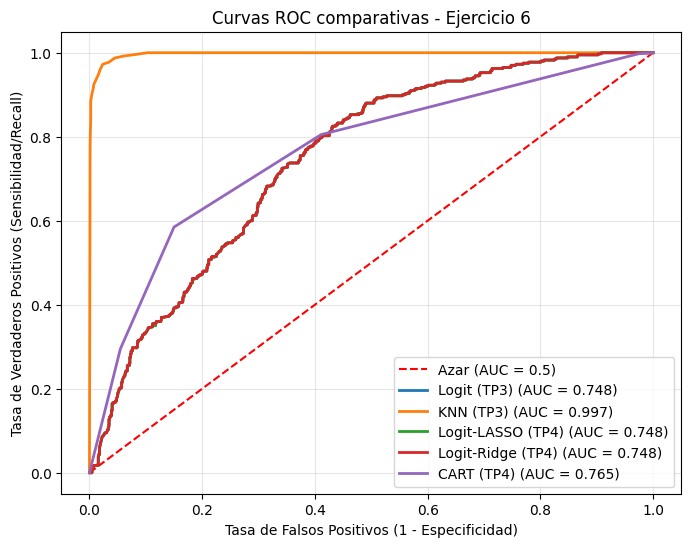

In [ ]:
plt.figure(figsize=(8,6))
plt.plot([0,1],[0,1],'r--', label='Azar (AUC = 0.5)')

for nombre, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.3f})", linewidth=2)

plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Sensibilidad/Recall)")
plt.title("Curvas ROC comparativas - Ejercicio 6")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


la roja, verde y azul estan en el mismo lugar

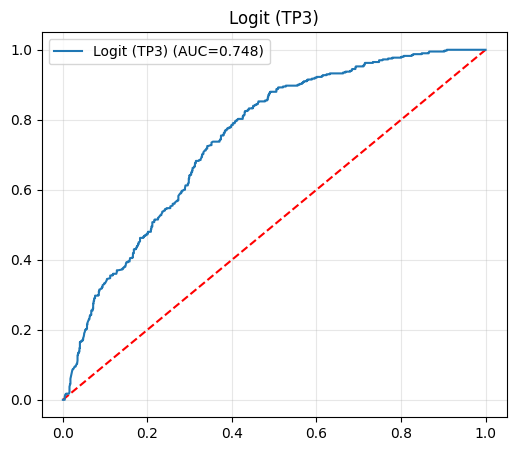

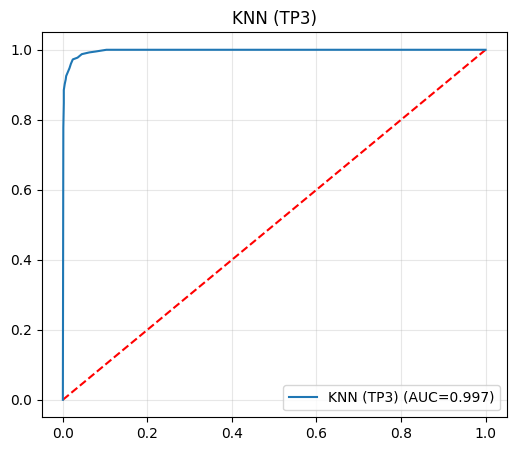

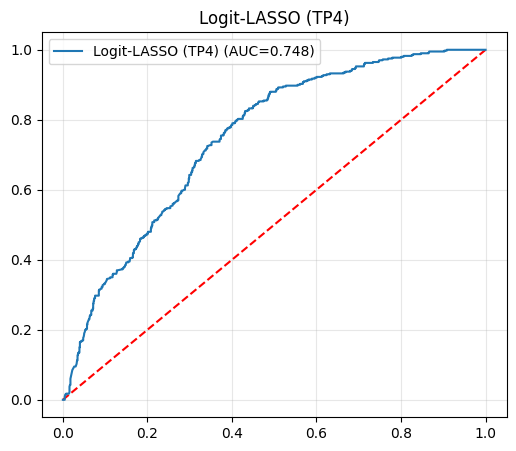

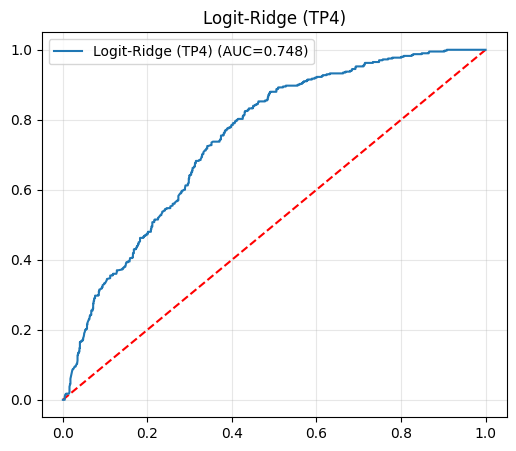

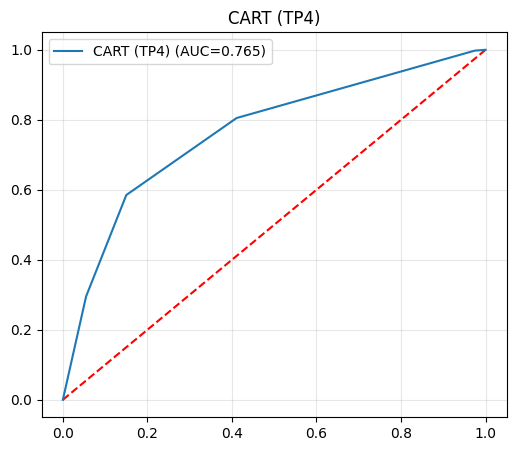

In [ ]:
for nombre, (fpr, tpr, auc) in roc_curves.items():
    plt.figure(figsize=(6,5))
    plt.plot([0,1],[0,1],'r--')
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
    plt.title(nombre)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
